## Tools

LLMs are limited by their knowledge and capabilities, they will answer only based on their training data. So to give them some super powers, we use tools.

In fact this is not a super power, because we still use them as LLMs where we talk with them in natural language. Think of it like, when LLM does not know anything, it knows it has some tools at its disposal, it calls them. So these tools are external to the LLM, designed by us. These tools only respond the required knowledge by the LLM, in natural language. Now the LLM got the knowledge, using which it gives the final response to the user.

#### Goal
In this tutorial, we will add a `Web Search` tool which will help our model to answer questions which it does not know. After all web search is the most powerful tool to keep our model up to date.

Use Tavily Search Engine tool https://www.tavily.com


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### 1. Define the tool

In [3]:
from langchain_tavily import TavilySearch
from pprint import pprint

web_search_tool = TavilySearch(max_results=2)
tools = [web_search_tool]
res = web_search_tool.invoke("What's a 'node' in LangGraph?")
pprint(res)

{'answer': None,
 'follow_up_questions': None,
 'images': [],
 'query': "What's a 'node' in LangGraph?",
 'response_time': 1.24,
 'results': [{'content': 'TL;DR: LangGraph is module built on top of LangChain '
                         'to better enable creation of cyclical graphs, often '
                         'needed for agent runtimes. This state is updated by '
                         'nodes in the graph, which return operations to '
                         'attributes of this state (in the form of a key-value '
                         'store). After adding nodes, you can then add edges '
                         'to create the graph. An example of this may be in '
                         'the basic agent runtime, where we always want the '
                         'model to be called after we call a tool. The state '
                         'of this graph by default contains concepts that '
                         "should be familiar to you if you've used LangChain "
     

### 2. Define the Graph

In [4]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# instead of directly invoking the llm we bind the tools first
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

### 3. Function to run tools

Here we define it from scratch but Langgraph has prebuilt solutions for tool node - `ToolNode`


In [6]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[web_search_tool])
graph_builder.add_node("tools", tool_node)

In [7]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(
            f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

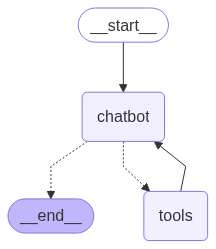

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Ask questions to chatbot

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Human:", user_input)
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Human: Hi, I am Shashank
Assistant: Hello Shashank, nice to meet you. How can I help you today?
Human: Whats the stock price of Google today?
Assistant: I cannot directly get the stock price of Google. However, I can search for it using the Tavily search engine. Would you like me to do that?
Human: Yes
Assistant: Okay. How can I help you today? What would you like to search for?
Human: Yes use the search engine
Assistant: Okay, I'm ready. What do you want me to search for?
Human: Stock price for google today
Assistant: I am sorry, I cannot directly get the stock price. But I can search for it using the search tool. Would you like me to do that?
Human: yes do that
Assistant: I'm sorry, I need more information to fulfill this request. What do you want me to do? Please provide a specific query or task.
Human: stock price of google
Assistant: 
Human: stock price of google
Assistant: {"query": "stock price of google", "follow_up_questions": null, "answer": null, "images": [], "results": [{"

Gemini is not calling the search tool on its own. It asks user if they want it to search web.